In [53]:
import os
os.environ['PYTHONHASHSEED']=str(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.set_random_seed(0)

# ## uncomment for reproducibility ##
# from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

import pandas as pd
import matplotlib.pyplot as plt
import pickle
import itertools
import time
import itertools
from IPython.display import display, clear_output

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.initializers import glorot_uniform

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
VERSION = '06'

directory= f'../models/{VERSION}'
if not os.path.exists(directory):
    os.makedirs(directory)

In [3]:
def play_bell():
    import winsound
    duration = 200  # millisecond
    freq = 440  # Hz
    for i in range(5):
        winsound.Beep(int(freq*(i/2+1)), duration)
        
class LossHistory(Callback):
    def __init__(self, number_of_epochs):
        self.number_of_epochs = number_of_epochs
        self.current_epoch = 0
    def on_train_begin(self, logs={}):
        self.initial_time = time.time()
    def on_batch_end(self, batch, logs={}):
        if logs['batch']==0:
            NUMBER_OF_DIESIS = 20
            self.current_epoch += 1
            progress = self.current_epoch/self.number_of_epochs
            diesis = np.round(progress*NUMBER_OF_DIESIS).astype('int')
            eta = (time.time()-self.initial_time) * (self.number_of_epochs/self.current_epoch -1)
            remaining_time = time.strftime("%Mmin %Ssec", time.gmtime(eta))
            print('\r[{}{}] acc:{:.3f} eta:{}'.format('#'*diesis, '-'*(NUMBER_OF_DIESIS-diesis), logs['acc'], remaining_time), end='')

## Hyperparameters setting

In [4]:
def create_grid(params={}, index=0):   
    best_model_path = '../models/{}/best_model_{}.pkl'.format(VERSION, index)
    
    current_grid = {
        'index'                  : [np.int    , index],
        'version'                : ['str'     , VERSION],
        'best_model_path'        : ['str'     , best_model_path],
        'params'                 : ['O'       , params],
        
        # Load and preprocess
        'batch_size_data'        : [np.int    , 200],
        'x_std'                  : [np.float  , 3.398],
        'y_std'                  : [np.float  , 2.926],
        'sigma_cut'              : [np.float  , 0.1],
        
        # Metrics
        'best_model_metric'      : ['str'     , 'val_acc'],
        'training_metric'        : ['str'     , 'accuracy'],
        
        # Random seeds
        'seed_skf'               : [np.int    , 0],
        'seed_numpy'             : [np.int    , 0],
        'seed_tensorflow'        : [np.int    , 0],
        'seed_random'            : [np.int    , 0],
        'seed_sklearn'           : [np.int    , 0],
        'seed_model'             : [np.int    , 0],
        
        # Model properties
        'input_shape'            : ['O'       , None],
        'LSTM_size'              : [np.int    , 256],        
        
        # Training parameters
        'learning_rate'          : [np.float  , 0.0001],
        'batch_size'             : [np.int    , 32],
        'epochs'                 : [np.int    , 200],
        'test_size'              : [np.float  , 0.15],
        'skf_n_splits'           : [np.int    , 5],
        'skf_split'              : [np.int    , 0],
        
        # Outputs
        'best_model_accuracy'    : [np.float  , 0],
        'fit_out'                : ['O'       , None]}

    for key, value in params.items():
        current_grid[key][1] = value
    return current_grid

def add_grid_and_save(grid):
    if os.path.isfile('../model_data/grid_{}.pkl'.format(grid['version'][1])):
        grid_df = pd.read_pickle('../model_data/grid_{}.pkl'.format(grid['version'][1]))
    else:
        grid_df = pd.DataFrame()
        for key in sorted(grid.keys()):
            grid_df[key] = pd.Series(dtype=grid[key][0])

    grid_df = grid_df.append({key:grid[key][1] for key in grid.keys()}, ignore_index=True)
    grid_df.to_pickle('../model_data/grid_{}.pkl'.format(grid['version'][1]))
    

## Dataset loading and preprocessing

In [5]:
from sklearn.model_selection import train_test_split
def load_data(grid):
    right = pd.read_csv("../data/right.txt", header=None).values.tolist()
    left = pd.read_csv("../data/left.txt", header=None).values.tolist()
    
    BATCH_SIZE = grid['batch_size_data'][1]
    batch_right = [right[i:i + BATCH_SIZE] for i in range(0, len(right), BATCH_SIZE)]
    batch_left = [left[i:i + BATCH_SIZE] for i in range(0, len(left), BATCH_SIZE)]

    X_load = np.array(batch_right + batch_left)
    y_load = np.array([0]*len(batch_right) + [1]*len(batch_left))

    X_train, X_test, y_train, y_test = train_test_split(X_load, y_load, test_size=0.15, random_state=42, shuffle=True)
    return X_train, X_test, y_train, y_test

In [6]:
def pre_process_data(X, y, grid):
    # relative mouse movement
    X_diff = X[:,:-1,:].copy()
    X_diff[:,:,0] = np.diff(X[:,:,0])
    X_diff[:,:,1] = np.diff(X[:,:,1])
    
    # remove batches with no mouse activity
    sigma_x = np.std(X_diff[:,:,0], axis=1)
    sigma_y = np.std(X_diff[:,:,1], axis=1)
    mask = (sigma_x>grid['sigma_cut'][1])*(sigma_y>grid['sigma_cut'][1])

    X_filt = X_diff[mask]
    y_filt = y[mask]

    
    # normalize data
    x_std = grid['x_std'][1] # np.mean(np.std(X_filt[:,:,0], axis=1))
    y_std = grid['y_std'][1] # np.mean(np.std(X_filt[:,:,1], axis=1))

    X_filt[:,:,0] = X_filt[:,:,0] / x_std
    X_filt[:,:,1] = X_filt[:,:,1] / y_std
    
    return X_filt, y_filt

## Model definition

In [7]:
def create_model(grid):
    model = Sequential()
    model.add(LSTM(grid['LSTM_size'][1], input_shape=grid['input_shape'][1], kernel_initializer=glorot_uniform(seed=grid['seed_model'][1])))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=grid['seed_model'][1])))
    return model


In [8]:
def train_model(X, y, model, grid):
    skf = StratifiedKFold(n_splits=grid['skf_n_splits'][1], shuffle=True, random_state=grid['seed_skf'][1])
    train_index, test_index = list(skf.split(X, y))[grid['skf_split'][1]]
    X_train, X_dev = X[train_index], X[test_index]
    y_train, y_dev = y[train_index], y[test_index]
    
    
    adam = Adam(lr=grid['learning_rate'][1])
    progrress_bar = LossHistory(grid['epochs'][1])
    chk = ModelCheckpoint(grid['best_model_path'][1] , monitor=grid['best_model_metric'][1],
                          save_best_only=True, mode='max', verbose=0) 
    
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[grid['training_metric'][1]])
    grid['fit_out'][1] = model.fit(X_train, y_train, epochs=grid['epochs'][1], batch_size=grid['batch_size'][1],
                        callbacks=[chk, progrress_bar], validation_data=(X_dev, y_dev), verbose=0)
    grid['fit_out'][1].model = None
    return grid

In [9]:
def run_training(X, y, grid, verbose=True):
    initial_time = time.time()
    np.random.seed(grid['seed_numpy'][1])
    tf.set_random_seed(grid['seed_tensorflow'][1])
    random.seed(grid['seed_random'][1])

    grid['input_shape'][1] = (X.shape[1], 2)
    model = create_model(grid)
    grid = train_model(X, y, model, grid)

    grid['best_model_accuracy'][1] = np.max(grid['fit_out'][1].history['val_acc'])

    
    add_grid_and_save(grid)
    total_time = time.strftime("%Mmin %Ssec", time.gmtime((time.time() - initial_time)))
    print('  --  Model {} trained in {}'.format(grid['index'][1], total_time))
    return grid



### Run training

In [10]:
grid = create_grid()

X_train, X_test, y_train, y_test = load_data(grid)
X_train, y_train = pre_process_data(X_train, y_train, grid)
X_test, y_test = pre_process_data(X_test, y_test, grid)

In [72]:
translate(1, 0, 1, 20, 250)

250.0

In [105]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction


def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = (value - leftMin) / leftSpan

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

def LSTM_scale(x):
    return int(translate(x, 0, 1, 20, 250))

def learning_rate_scale(x):
    x = translate(x, 0, 1, -5, -2)
    return 10**x

def LSTM_scale_back(x):
    return translate(x, 20, 250, 0, 1)

def learning_rate_scale_back(x):
    x = np.log10(x)
    return translate(x, -5, -2, 0, 1)

def test_params(LSTM_size, learning_rate):
    LSTM_size = LSTM_scale(LSTM_size)
    learning_rate = learning_rate_scale(learning_rate)
    
    print(f'Testing LSTM_size={LSTM_size} learning_rate={learning_rate}')
    
    params = {'LSTM_size': LSTM_size, 'learning_rate':learning_rate}
    grid = create_grid(params, index+initial_index)
    grid = run_training(X_train, y_train, grid, verbose=True)
    return grid['best_model_accuracy'][1]

Testing LSTM_size=250 learning_rate=0.00024508825012671813
[--------------------] acc:0.469 eta:05min 40sec

KeyboardInterrupt: 

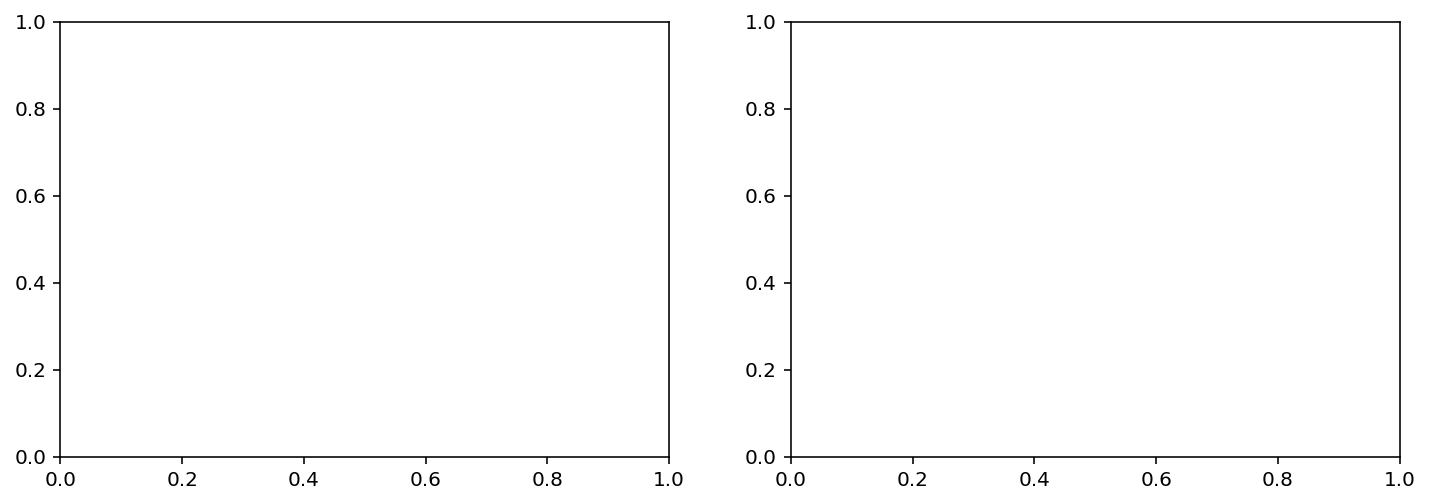

In [106]:
%%time

optimizer = BayesianOptimization(
    f=test_params,
    pbounds={'LSTM_size': (0, 1), 'learning_rate': (0, 1)},
    verbose=0,
    random_state=30)


utility = UtilityFunction(kind="ucb", kappa=1., xi=None)


## BAYESIAN SEARCH
if not os.path.isfile('../model_data/grid_{}.pkl'.format(VERSION)):
    initial_index = 0
else:
    grid_df = pd.read_pickle('../model_data/grid_{}.pkl'.format(VERSION))
    initial_index = grid_df['index'].max() + 1
    
    for point, acc in zip(grid_df['params'], grid_df['best_model_accuracy']):
        point['LSTM_size'] = LSTM_scale_back(point['LSTM_size'])
        point['learning_rate'] = learning_rate_scale_back(point['learning_rate'])
        optimizer.register(params=point, target=acc)
        

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for i in range(10):
    index = i + initial_index
    next_point_to_probe = optimizer.suggest(utility)    
    target = test_params(**next_point_to_probe)
    optimizer.register(params=next_point_to_probe, target=target)
    

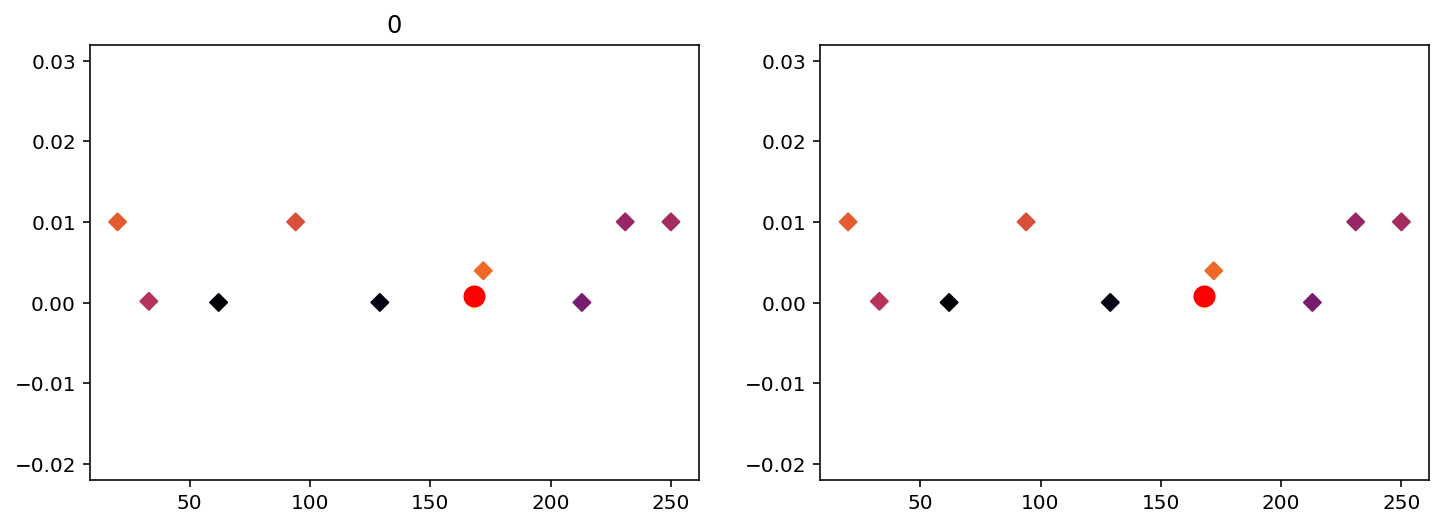

In [124]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

optimizer = BayesianOptimization(
    f=test_params,
    pbounds={'LSTM_size': (0, 1), 'learning_rate': (0, 1)},
    verbose=0,
    random_state=30)

utility = UtilityFunction(kind="ucb", kappa=1., xi=None)


## BAYESIAN SEARCH
if not os.path.isfile('../model_data/grid_{}.pkl'.format(VERSION)):
    initial_index = 0
else:
    grid_df = pd.read_pickle('../model_data/grid_{}.pkl'.format(VERSION))
    initial_index = grid_df['index'].max() + 1

    for point, acc in zip(grid_df['params'], grid_df['best_model_accuracy']):
        point['learning_rate'] = learning_rate_scale_back(point['learning_rate'])
        point['LSTM_size'] = LSTM_scale_back(point['LSTM_size'])
        optimizer.register(params=point, target=acc)

optimizer.suggest(utility)


x_grid = np.array([learning_rate_scale(x) for x in np.linspace(0, 1, 100)])
y_grid = np.array([LSTM_scale(x) for x in np.linspace(0, 1, 100)])

space = optimizer.space
xx, yy = np.meshgrid(x_grid, y_grid)
x, y = optimizer.max['params']['LSTM_size'], optimizer.max['params']['learning_rate']

XY = np.append(xx, yy).reshape(-1, 2, order='F')
mean, sigma = optimizer._gp.predict(XY , return_std=True)

for ax in (ax1, ax2):
    ax.cla()
    ax.scatter([LSTM_scale(x) for x in space.params[:,0]],
               [learning_rate_scale(x) for x in space.params[:,1]], zorder=3, c=space.target, cmap='inferno', marker='D')
    ax.scatter(LSTM_scale(x), learning_rate_scale(x), color='red', s=100, zorder=8)
#ax1.contourf(x_grid, y_grid, mean.reshape(xx.shape), 90, zorder=1)
#ax2.contourf(x_grid, y_grid, sigma.reshape(xx.shape), 90, zorder=1)
ax1.set_title(i)
display(fig)
clear_output(wait = True)

In [122]:
optimizer.suggest(utility)


{'LSTM_size': 1.0, 'learning_rate': 0.46310716317886774}

In [199]:
optimizer._gp.predict(np.array([159., -5.]).reshape(-1,2))


array([0.68705883])

In [34]:
best_model_path = grid_df.loc[grid_df['best_model_accuracy'].idxmax()]['best_model_path']
best_model = load_model(best_model_path)

In [31]:
mean

array([[1.00000000e-05, 1.00000000e-05, 1.00000000e-05, ...,
        1.00000000e-05, 1.00000000e-05, 1.00000000e-05],
       [1.10909091e-04, 1.10909091e-04, 1.10909091e-04, ...,
        1.10909091e-04, 1.10909091e-04, 1.10909091e-04],
       [2.11818182e-04, 2.11818182e-04, 2.11818182e-04, ...,
        2.11818182e-04, 2.11818182e-04, 2.11818182e-04],
       ...,
       [9.79818182e-03, 9.79818182e-03, 9.79818182e-03, ...,
        9.79818182e-03, 9.79818182e-03, 9.79818182e-03],
       [9.89909091e-03, 9.89909091e-03, 9.89909091e-03, ...,
        9.89909091e-03, 9.89909091e-03, 9.89909091e-03],
       [1.00000000e-02, 1.00000000e-02, 1.00000000e-02, ...,
        1.00000000e-02, 1.00000000e-02, 1.00000000e-02]])

In [270]:
test_preds = model.predict_classes(X_test)
acc_test = accuracy_score(y_test, test_preds)
print(f'Accuracy on the test set: {acc_test*100:.1f}%')

Accuracy on the test set: 55.6%


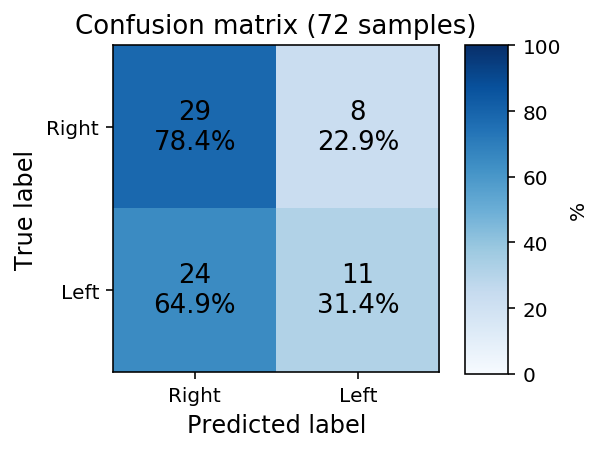

In [272]:
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, test_preds)
# cm = confusion_matrix(y_dev, dev_preds)
#cm = confusion_matrix(y_train, training_preds)

classes=['Right', 'Left']
fig, ax = plt.subplots(1, figsize=(3,3))
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

cm_norm = cm / cm.sum(axis=1)*100
im = ax.imshow(cm_norm, cmap='Blues', interpolation='none', clim=(0,100))
ax.set_title(f'Confusion matrix ({y_test.shape[0]} samples)', size=13)


for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, f'{cm[i,j]}\n{cm_norm[i, j]:.1f}%', size=13,
             horizontalalignment="center", verticalalignment="center",
             color="white" if cm[i, j] > 60 else "black")
ax.set_ylabel('True label', size=12)
ax.set_xlabel('Predicted label', size=12)

cb_ax = fig.add_axes([0.95, 0.12, 0.1, 0.76])
cb = fig.colorbar(im, cax=cb_ax, orientation='vertical')
cb.set_label('%')

fig.savefig(f'../plots/conf_matrix_{version}.png', bbox_inches='tight')

## working anim

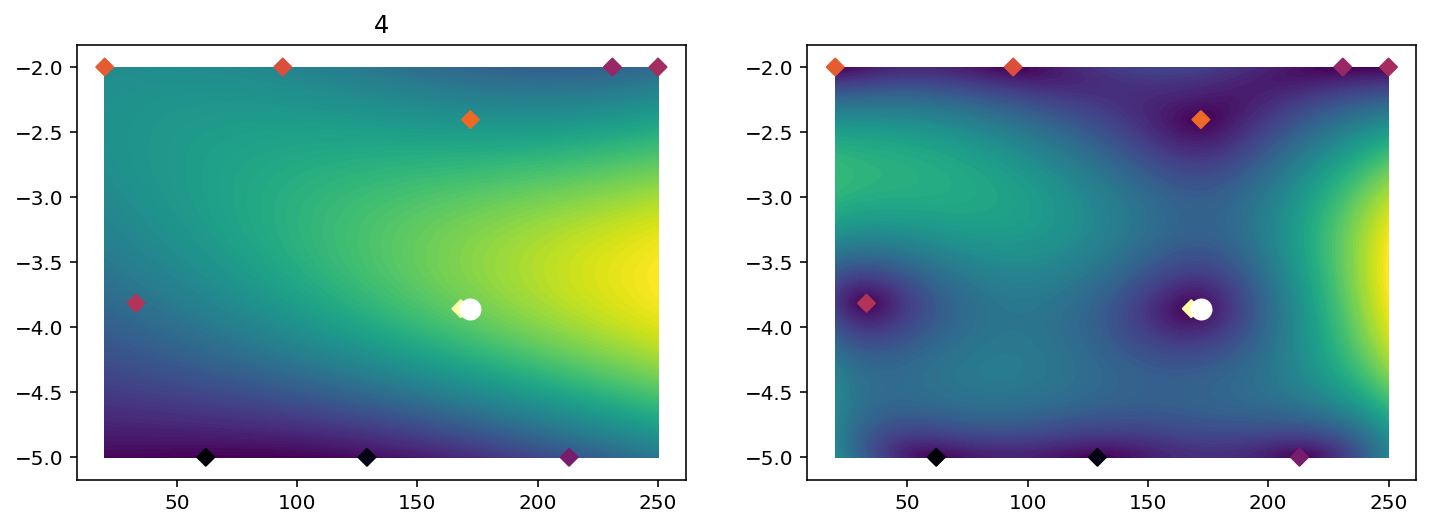

In [19]:
from IPython.display import display, clear_output
import time

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))



for i in range(5):
    optimizer = BayesianOptimization(
        f=test_params,
        pbounds={'LSTM_size': (20, 250), 'learning_rate': (-5, -2)},
        verbose=0,
        random_state=30)

    utility = UtilityFunction(kind="ucb", kappa=1., xi=None)


    ## BAYESIAN SEARCH
    if not os.path.isfile('../model_data/grid_{}.pkl'.format(VERSION)):
        initial_index = 0
    else:
        grid_df = pd.read_pickle('../model_data/grid_{}.pkl'.format(VERSION))
        initial_index = grid_df['index'].max() + 1

        for point, acc in zip(grid_df['params'], grid_df['best_model_accuracy']):
            point['learning_rate'] = np.log10(point['learning_rate'])
            point['LSTM_size'] = point['LSTM_size']/100
            optimizer.register(params=point, target=acc)

    optimizer.suggest(utility)

    grid_df = pd.read_pickle('../model_data/grid_{}.pkl'.format(VERSION))


    xs = grid_df['LSTM_size']
    ys = grid_df['learning_rate']
    zs = grid_df['best_model_accuracy']
    
    x_grid = np.linspace(20, 250, 100)/100
    y_grid = np.linspace(-5, -2, 100)
    space = optimizer.space
    xx, yy = np.meshgrid(x_grid, y_grid)
    x, y = optimizer.max['params']['LSTM_size'], optimizer.max['params']['learning_rate']

    XY = np.append(xx, yy).reshape(-1, 2, order='F')
    mean, sigma = optimizer._gp.predict(XY , return_std=True)

    for ax in (ax1, ax2):
        ax.cla()
        ax.scatter(space.params[:,0]*100, space.params[:,1], zorder=3, c=space.target, cmap='inferno', marker='D')
        ax.scatter(x*100+i, y, color='white', s=100, zorder=8)
    ax1.contourf(x_grid*100, y_grid, mean.reshape(xx.shape), 90, zorder=1)
    ax2.contourf(x_grid*100, y_grid, sigma.reshape(xx.shape), 90, zorder=1)
    ax1.set_title(i)
    display(fig)
    clear_output(wait = True)